# Digit Recognizer - A Deep Learning Approach

## Why use deep learning?

Deep learning has substantially pushed the state-of-the-art in a wide range of tasks, including speech recognition, image recognition, and object detection. In 2012, deep neural networks shocked the world by halving the error rate in the ImageNet contest, and precipitated the rapid adoption of deep learning by the whole community. From then on, practitioners just don't get any result if they don't use deep learning. Therefore, let's take a look at this hottest technique.


## Why recognize digits?

Recognizing digits with MNIST dataset is the hello world example in the machine learning world. Specifically, it is simple, but illustrative enough. For those who take 688, you must have got familiar with it during lab4, and we reuse some code from lab4 to maintain the consistency. For those who don't, The MNIST database is a large database of handwritten digits (0-9) that contains 60,000 training images and 10,000 testing images. Each image is a 28×28 pixel image. Below are the code for loading the database into numpy array. 


In [17]:
import numpy as np
import struct

def parse_images(filename):
    f = open(filename,"rb");
    magic,size = struct.unpack('>ii', f.read(8))
    sx,sy = struct.unpack('>ii', f.read(8))
    X = []
    for i in range(size):
        im =  struct.unpack('B'*(sx*sy), f.read(sx*sy))
        X.append([float(x)/255.0 for x in im]);
    return np.array(X).transpose();

def parse_labels(filename):
    f = open(filename,"rb");
    magic,size = struct.unpack('>ii', f.read(8))
    return np.array(struct.unpack('B'*size, f.read(size)))

train_images = parse_images("train-images-idx3-ubyte")
train_labels = parse_labels("train-labels-idx1-ubyte")
test_images = parse_images("t10k-images-idx3-ubyte")
test_labels = parse_labels("t10k-labels-idx1-ubyte")

Also, let's have a look at some samplings of the digits, such that we have a feeling of the database.

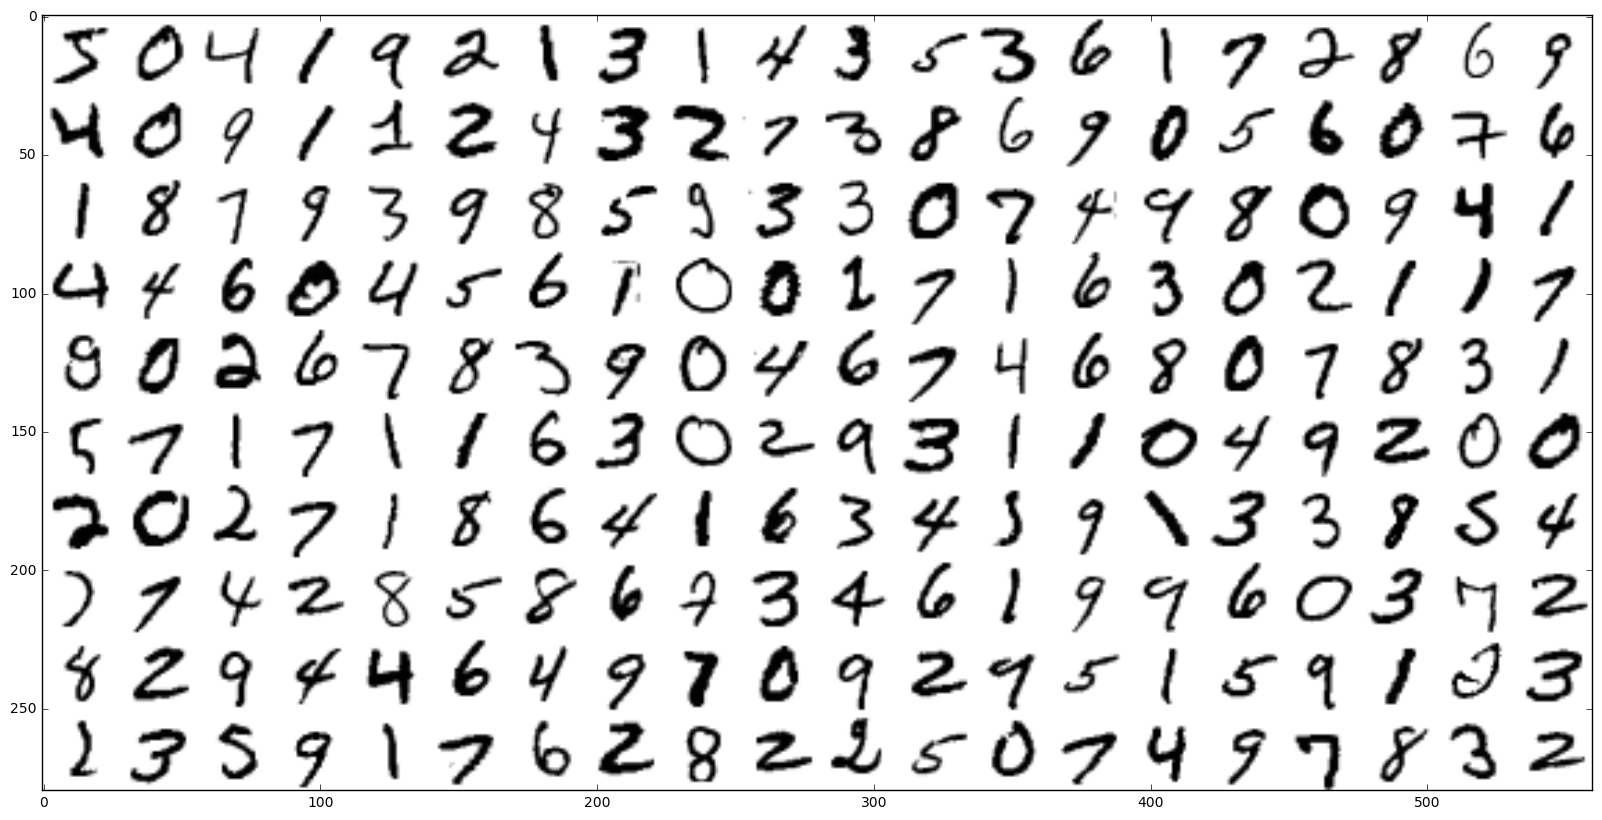

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

M,N = 10,20
fig, ax = plt.subplots(figsize=(N,M))
digits = np.vstack([np.hstack([np.reshape(X_train[i*N+j,:],(28,28)) 
                               for j in range(N)]) for i in range(M)])
ax.imshow(255-digits, cmap=plt.get_cmap('gray'))

## What is deep learning?

Deep, in its appearance, means that the networks have great depth, i.e. have many layers of hidden units. 20 years ago a typical neural network had 3-5 layers of hidden units, while recently Microsoft researchers won the ImageNet contest with 152 layers neural networks!

However, deep learning is not just stacking layer over layer. Without modern architectures and techniques, a deeper network, with hundreds of millions of parameters, may suffer from (to name a few):
1. Hard to train.
2. Overfitting.

To solve these issues, scientists introduced new architectures, like convolutional networks, and new training techniques, like dropout. Therefore, Deep Neural Networks (DNNs), in essence, are neural networks with modern architectures, and are trained with modern techniques. In this tutorial, we will first introduce a simple neural network, and then proceed to some cool deep techniques.

## Multiclass classification and one-hot representation

Classification of the digits is a multiclass (10 classes) classification. In binary classification problem, we use 0 to represent one class, while use 1 to represent another. This can be easily extended to the multiclass scenario. Specifically, assuming we have $C$ classes, we use a binary vector of length C, all except one of which are zeros, and thus it is called one-hot. Say the original label is k, then only the kth element of the one-hot vector is 1. Below is the code for converting dense labels to one-hot labels.

In [44]:
def dense_to_one_hot(labels_dense, num_classes=10):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return np.transpose(labels_one_hot)

train_labels = dense_to_one_hot(train_labels)
test_labels = dense_to_one_hot(test_labels)


## Neural networks

Neural networks are made of a collection of neurons, and each neuron takes multiple inputs and then outputs usually a binary value. As in the lab 3, we add a bias $b$ to the input, and the weight $w_0$ for bia is usually set as 1. Below shows a single neuron. Mathematically, the output $y$ satisfies the following formula:

$$y = \sigma(w_1x_1 + w_2x_2 + b)$$

where $\sigma(x)$ is the sigmoid function, and is defined as $\sigma(x) = \frac{1}{1 + \exp(-x)}$. The sigmoid is also called activation function, which limits the output between 0 and 1. If $y > 0.5$, the neuron is activated; otherwise, it is deactivated. 

![title](single-neuron.png)

One of the most powerful ability of neural networks is that they can, rather than need to be fed with manually crafted features, directly learn abstract representations from the raw input. Therefore, all we need to do is to construct a network and throw all inputs to it. In our case, we have 28 $\times$ 28 pixel images, and thus the size of input is 784. The output size is 10, as we have 10 classes in one-hot representation. Also, we need to have some neurons in between input and output to model the underlying mapping between pixels and classes. As a first attempt, let's use one layer of neurons and set the size of neurons as 256. (You may ask why we choose 256. The answer is that it does not matter once it is within a range, and you can choose whatever you like. 256 is a power of 2.)

For simplicity of mathematical notation, we introduce the matrix formulation of the previous equation. Now, the input $\mathbf{x}$ is a vector of 784 elements, the weight matrix $\mathbf{W_1}$ is 256 $\times$ 784, $\mathbf{W_2}$ is 10 $\times$ 256, and the output $\mathbf{y}$ is a vector of 10 elements.

$$h(\mathbf{x}) = \sigma(\mathbf{W_1}\mathbf{x} + \mathbf{b_1})$$
$$\mathbf{y} = \sigma(\mathbf{W_2}h(\mathbf{x}) + \mathbf{b_2})$$

Finally, we should classify the image as the digit we think is most probable. Hence, we should use maximum. However, we instead use soft maximum function here, as it is easier to compute its gradient, which will benefit our stochastic gradient descent optimization later. The softmax function is defined as:

$$ p(y = i) = exp(y_i)/\sum_{j=0}^{C}{exp(y_j)}$$

Intuitively, the softmax function outputs a number between 0 and 1, which can be viewed as the probability of the image belonging to a certain class. For better understanding, the architecture of the network is illustrated in the following graph (bias is omitted).

![title](one-layer-network1.png)

Also, the corresonding piece of code is shown below.


In [19]:
def softmax(x):
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x, 0)
    return np.divide(exp_x, sum_exp_x)

def feed_forward(x, W1, b1, W2, b2):
    h1 = sigmoid(np.add(np.matmul(W1, x), b1))
    y = sigmoid(np.add(np.matmul(W2, h1), b2))
    p = softmax(y)
    return h1, y, p

Great! We have officially finished the so-called feed-forward process of neural networks. Now, we have many adjustable parameters, $\mathbf{W_1}$, $\mathbf{W_2}$, $\mathbf{b_1}$, and $\mathbf{b_2}$, it is time to learn these parameters. 

Image that the network outputs a vector (0.1, 0.1, ..., 0.1) for a certain image, while the label for this image is 0. Thus, the one-hot representation is (1, 0, 0, ..., 0). Certainly, we want the network's output to match the one-hot representation, i.e. increase the probability of outputing 0, and decrease the probability of other digits. Thus, we want to change the output $\mathbf{y}$ by ($\Delta y$, $-\Delta y$, $-\Delta y$, ..., $-\Delta y$), where $\Delta y$ is a small positive number, by changing individual parameters, say $b_1$. Apparently, this is where gradient should come into the scene. Specifically, the new $b_1$ should be set as something like:

$$b_1 = b_1 + \alpha \frac{\partial{\Delta \mathbf{y}}}{\partial{b_1}}$$

where $\alpha$ is a hyper-parameter we should decide later. Also, $\alpha$ controls how far each step we take, and thus is known as the learning rate. 

Until now the $\Delta y$ part is just intuition, we want to formalize it mathematically. As we mentioned before, the output of softmax function is the probability that one image belongs to a certain class. Therefore, we can construct a MLE estimator, and we hope to maximize the likelihood. Given a certain image, we obtain:

$$ p_{MLE} = \prod_{i=0}^{C}{p_i}^{t_i} $$

where $t_k = 1$ if $k$ is the true label. Note that when $t_i = 0$, ${p_i}^{t_i}$ gives a one, and when $t_i = 1$, it gives $p_i$. Thus, this is equivalent to maximize $p_k$, where $k$ is the correct label. However, this mathematical notation makes the manipulation simpler. Moreover, equivalently, it is usually more convenient to minimize the negative log-likehood, and we call it loss function. Also, this famous loss function is named as cross-entropy loss.

$$ L = -\sum_{i=0}^{C}{t_i}\log{p_i} $$

Therefore, instead of using $\Delta \mathbf{y}$, formally, we have the update rule as:

$$\mathbf{W} = \mathbf{W} - \alpha \frac{\partial{L}}{\partial{\mathbf{W}}}$$
$$\mathbf{b} = \mathbf{b} - \alpha \frac{\partial{L}}{\partial{\mathbf{b}}}$$

Since $L$ is a function of $\mathbf{p}$ and $\mathbf{p}$ is function of $\mathbf{y}$, we denote as $L = o(\mathbf{y})$. According to the chain rule in calculus, it is easy to get 

$$\frac{\partial{L}}{\partial{\mathbf{W_2}}} = 
\frac{\partial{L}}{\partial{\mathbf{y}}}
\frac{\partial{\mathbf{y}}}{\partial{\mathbf{W_2}}}$$

$$\frac{\partial{L}}{\partial{\mathbf{b_2}}} = 
\frac{\partial{L}}{\partial{\mathbf{y}}}
\frac{\partial{\mathbf{y}}}{\partial{\mathbf{b_2}}}$$

$$\frac{\partial{L}}{\partial{\mathbf{W_1}}} = 
\frac{\partial{L}}{\partial{\mathbf{y}}}
\frac{\partial{\mathbf{y}}}{\partial{h(\mathbf{x})}}
\frac{\partial{h(\mathbf{x})}}{\partial{\mathbf{W_1}}}$$

$$\frac{\partial{L}}{\partial{\mathbf{b_1}}} = 
\frac{\partial{L}}{\partial{\mathbf{y}}}
\frac{\partial{\mathbf{y}}}{\partial{h(\mathbf{x})}}
\frac{\partial{h(\mathbf{x})}}{\partial{\mathbf{b_1}}}$$

Think of this procedure: we first have the loss w.r.t \mathbf{y}, which is the term $\frac{\partial{L}}{\partial{\mathbf{y}}}$. Then, based on this term, we can calculate the loss w.r.t. $\mathbf{W_2}$ and $\mathbf{b_2}$ as well as $h(\mathbf{x})$, which is $\frac{\partial{L}}{\partial{\mathbf{y}}}
\frac{\partial{\mathbf{y}}}{\partial{h(\mathbf{x})}}$. Finally, based on the loss w.r.t. $h(\mathbf{x})$, we can compute the loss w.r.t. $\mathbf{W_1}$ and $\mathbf{b_1}$. The process looks like we are propagating the loss from $L$ to $\mathbf{y}$ to $h(\mathbf{x})$ and finally to every parameter, and this is exactly why this learning process is named back-propagation.

With simple calculus and some mathematical manipulation, we have get the value of each component for the above rules. To save some space, here list some important results as an example: 

$$\frac{\partial{L}}{\partial{\mathbf{y}}} = \mathbf{p} - \mathbf{t}$$
$$\frac{\partial{\mathbf{y}}}{\partial{\mathbf{b_1}}} = \mathbf{y}(1-\mathbf{y})$$
$$\frac{\partial{\mathbf{y}}}{\partial{h(\mathbf{x})}} = \mathbf{W_2^T}\mathbf{y}(1-\mathbf{y})$$

Interestingly, the loss w.r.t. y is $\mathbf{p} - \mathbf{t}$, which exactly matches our intuition. Thus, we can actually view loss functions as a mathematically formulation of our intuition.

All of above is the famous optimization technique gradient descent. One thing left is that we need to repeatedly apply these update rules until the loss function reaches a local minimum (Optimization of neural networks is non-convex, and this is also part of the reason why we need to use gradient descent). Basically, the loss on the training set will keep going down, but we actually desire to have a high accuracy on the test set. They are not equivalent. One thing is overfitting. Generally, the loss on the test set will decrease first and then after some points begin to increase. Therefore, we hope to stop before the loss on the test set go up. A common approach is to specify a maximum amount of steps for taking gradient, which can be selected based on cross-validation. 

Before we proceed to training, we first need to figure out some ways to evaluate our approach. Also, this acts like a debugging technique to make sure our code really works. Basically, we have four ways: the loss and error rate on the training set, and the loss and error on the test set. Specifically, during training, we are pretty sure that the loss function on the training must decrease, and the error rate should have a decreasing trend. For the test set, we need to evaluate the result after training, and see how well our result can generalize.

The evaluation code is as follows.


In [37]:
def cross_entropy(y, truth):
    entropy = -np.add(np.multiply(truth, np.log(y)), \
                  np.multiply(-np.subtract(truth, 1), np.log(-np.subtract(y, 1))))
    mean_entropy = np.sum(entropy) / entropy.shape[1]
    return mean_entropy

def error_rate(y, truth):
    return np.mean(np.argmax(truth, 0) != np.argmax(y, 0))

def evaluate(y, truth):
    loss = cross_entropy(p, truth)
    error = error_rate(p, truth)
    return loss, error

Finally, we can start our training code. For now, we have two hyper-parameters, learning rate and epochs, and we, somewhat randomly, set them as 1e-4 and 100 in the following code.

In [54]:
def weight_variables(dim1, dim2, variance):
    matrix = np.multiply(2, np.random.rand(dim1, dim2))
    matrix = np.multiply(np.subtract(matrix, 1), variance)
    return matrix

def bias_variables(dim1, dim2, variance):
    matrix = np.ones((dim1, dim2))
    matrix = np.multiply(matrix, variance)
    return matrix

def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x)) # sigmoid


import math

num_hidden_units = 256
learn_rate = 1e-4
epochs = 200

images = train_images
labels = train_labels

variance1 = math.sqrt(6.0) / (784.0 + num_hidden_units)
W1 = weight_variables(num_hidden_units, 784, variance1)
b1 = bias_variables(num_hidden_units, 1, 0)

variance2 = math.sqrt(6.0) / (10.0 + num_hidden_units)
W2 = weight_variables(10, num_hidden_units, variance2)
b2 = bias_variables(10, 1, 0)

images_transposed = np.transpose(images)
images_ones = np.ones((images_transposed.shape[0], 1))

for epoch in range(0, epochs):
    h1, y, p = feed_forward(images, W1, b1, W2, b2)

    # every 20 steps print train loss and error rate
    if epoch % 20 == 0:
        train_loss, train_error = evaluate(p, train_labels)
        print "training loss", train_loss, "training error:", train_error
    
    h1_tranposed = np.transpose(h1)
    
    loss_derivative = np.subtract(p, labels)
    output = np.multiply(loss_derivative, np.multiply(y, (1-y)))
    hidden = np.multiply(np.matmul(np.transpose(W2), output), np.multiply(h1, (1-h1)))

    W2_gradient = np.matmul(output, h1_tranposed)
    b2_gradient = np.matmul(output, np.ones((h1_tranposed.shape[0], 1)))
    W2 = np.subtract(W2, np.multiply(learn_rate, W2_gradient))
    b2 = np.subtract(b2, np.multiply(learn_rate, b2_gradient))

    W1_gradient = np.matmul(hidden, images_transposed)
    b1_gradient = np.matmul(hidden, images_ones)
    W1 = np.subtract(W1, np.multiply(learn_rate, W1_gradient))
    b1 = np.subtract(b1, np.multiply(learn_rate, b1_gradient))

_, _, p = feed_forward(train_images, W1, b1, W2, b2)
train_loss, train_error = evaluate(p, train_labels)
print "training loss", train_loss, "training error:", train_error
_, _, p = feed_forward(test_images, W1, b1, W2, b2)
test_loss, test_error = evaluate(p, test_labels)
print "test loss", test_loss, "test error:", test_error

training loss 3.25064678292 training error: 0.887633333333
training loss 3.20428458326 training error: 0.846083333333
training loss 2.76691405222 training error: 0.325966666667
training loss 2.63884964838 training error: 0.309883333333
training loss 2.56982048941 training error: 0.2524
training loss 2.52559156841 training error: 0.2132
training loss 2.49819515957 training error: 0.188183333333
training loss 2.47981450903 training error: 0.1759
training loss 2.46614326558 training error: 0.16835
training loss 2.45483191902 training error: 0.1654
training loss 2.44510834604 training error: 0.16915
test loss 2.43895755975 test error: 0.166


## Going deeper

Actually, the above is just the simplest neural network, and the final error rate is pretty bad in neural networks' world. To make it better, we will introduce several more advanced techniques, stochastic gradient descent, weight decay, momentum, and dropout.